<h1><center><font size=5>EFC 3</font></center></h1>
<h2><center><font size=3>
Jimi Togni - RA: 226359
<br>
Rodrigo de Freitas Pereira -  RA: 192063
</font></center></h2>

<h3>1. Parte I - Devivação</h3>

$Z$ = Camada intermediária da rede.

$outZ$ = Saída da camada Z (de acordo com a função de ativação).

$inpZ$ = Entrada da camada Z (amostras de entrada).

$\hat y$ = Ground true

De forma geral temos a seguinte derivação para a retropopagação do erro para qualquer $v_{n}$.

$\frac{\partial J}{\partial v_{n}} = \frac{\partial J}{\partial outZ}\frac{\partial outZ}{\partial inpZ}\frac{\partial inpZ}{\partial v_n}$

No caso específico para $v_{12}$ temos:

$\frac{\partial J}{\partial v_{12}} = \frac{\partial J}{\partial outZ}\frac{\partial outZ}{\partial inpZ}\frac{\partial inpZ}{\partial v_{12}}$

Realizando as derivadas expostas acima:

$\frac{\partial J}{\partial outZ} = \sum_{n=1}^N(\hat y - y) w_n$

$\frac{\partial outZ}{\partial inpZ} = f(.)$

$\frac{\partial inpZ}{\partial v_n} = x_n$

Então para $v_{12}$:

$\frac{\partial J}{\partial outZ} = (\hat y_1 - y_1)w_{30} + (\hat y_2 - y_2)w_{31}$

$\frac{\partial outZ}{\partial inpZ} = f(.)$

$\frac{\partial inpZ}{\partial v_12} = x_1$

Finalmente:

$\frac{\partial J}{\partial v_{12}} = ((\hat y_1 - y_1)w_{30} + (\hat y_2 - y_2)w_{31}) \times f(.) \times x_1$


In [33]:
import gc

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

from mlxtend.plotting import plot_decision_regions

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.optimizers import SGD, RMSprop, Adam

%matplotlib inline

<h3>##########################################################################################</h3>
<h3>2. Parte II – Classificação binária com redes MLP e SVMs</h3>

<p>
<h4>Plotando os dados do problema</h4>
</p>

In [34]:
dataset_treino = scipy.io.loadmat("./dados/dados_treinamento.mat")
dataset_val = scipy.io.loadmat("./dados/dados_val.mat")
dataset_teste = scipy.io.loadmat("./dados/dados_teste.mat")

X_treino = dataset_treino["X"]
y_treino = dataset_treino["y"]
X_val = dataset_val["Xval"]
y_val = dataset_val["yval"]
X_teste = dataset_teste["Xt"]
y_teste = dataset_teste["yt"]

y_treino[y_treino == -1] = 0
y_val[y_val == -1] = 0
y_teste[y_teste == -1] = 0

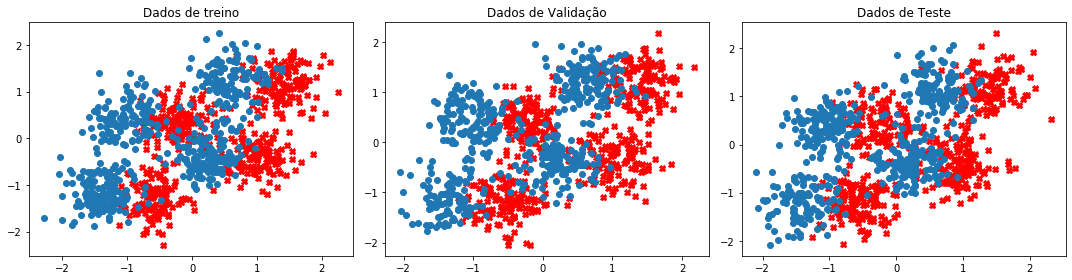

In [38]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(X_treino[np.in1d(y_treino, 1), 0], X_treino[np.in1d(y_treino, 1), 1], 'rX')
plt.plot(X_treino[np.in1d(y_treino, 0), 0], X_treino[np.in1d(y_treino, 0), 1], 'o')
plt.title("Dados de treino")

plt.subplot(1, 3, 2)
plt.plot(X_val[np.in1d(y_val, 1), 0], X_val[np.in1d(y_val, 1), 1], 'rX')
plt.plot(X_val[np.in1d(y_val, 0), 0], X_val[np.in1d(y_val, 0), 1], 'o')
plt.title("Dados de Validação")

plt.subplot(1, 3, 3)
plt.plot(X_teste[np.in1d(y_teste, 1), 0], X_teste[np.in1d(y_teste, 1), 1], 'rX')
plt.plot(X_teste[np.in1d(y_teste, 0), 0], X_teste[np.in1d(y_teste, 0), 1], 'o')
plt.title("Dados de Teste")

plt.tight_layout()
plt.show()

In [39]:
treinamento = scipy.io.loadmat("./dados/dados_treinamento.mat")
validacao = scipy.io.loadmat("./dados/dados_val.mat")
teste = scipy.io.loadmat("./dados/dados_teste.mat")

In [40]:
x_treino = pd.DataFrame(treinamento["X"]).astype('float32')
y_treino = np.array(treinamento["y"]).ravel().astype('float32')
y_treino_view = y_treino
y_treino = pd.get_dummies(y_treino)

x_validacao = pd.DataFrame(validacao["Xval"]).astype('float32')
y_validacao = np.array(validacao["yval"]).ravel().astype('float32')
y_validacao_view = y_validacao
y_validacao = pd.get_dummies(y_validacao)

x_teste = pd.DataFrame(teste["Xt"]).astype('float32')
y_teste = np.array(teste["yt"]).ravel().astype('float32')
y_teste_view = y_teste
y_teste = pd.get_dummies(y_teste)

x_min, x_max = x_teste.to_numpy()[:, 0].min() - 1, x_teste.to_numpy()[:, 0].max() + 1
y_min, y_max = x_teste.to_numpy()[:, 1].min() - 1, x_teste.to_numpy()[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))


<h3>##########################################################################################</h3>
<h3>2.1 - Aplicando a MLP</h3>

In [ ]:
md = MLPClassifier(**{
    'activation': 'relu', 
    'hidden_layer_sizes': (100, ), #merlhor 100
    'learning_rate': 'constant', 
    'learning_rate_init': 1e-4, #merlhor 3
    'batch_size': 28, #merlhor 32
    'max_iter': 1000, #merlhor 1000
    'solver': 'adam',
    'random_state': 1
})
md.fit(x_treino, y_treino_view)

<h3>2.1.1 - MLP - Teste 1:</h3>

<p>
<h4>Hiperparametros Utilizados:</h4>

- Função de ativação: relu <br>
- Neuronios na camada oculta: 100<br>
- Taxa de aprendizado: constant <br>
- Taxa de aprendizado inicial: 1e-4 <br>
- Tamanho do mini-batch: 28 <br>
- Iterações maximas: 1000<br>
- solver: adam<br>
<br><br>
<h4>Utilizando a classe MLPClassifier da biblioteca sklearn</h4></p>

In [19]:
print('_' * 60)
print('--- Alguns valores importantes a se destacar ---')
print('_' * 60)
print('Neurônios nas camadas ocultas: 100')
print('Funçã de ativação: ReLu')
print('Tamanho do batch: 28')
print('Solver: Adam')
print('Passo de aprendizado: 1e-4')
print('Iterações máximas: 1000')
print('_' * 60)


____________________________________________________________
--- Alguns valores importantes a se destacar ---
____________________________________________________________
Neurônios nas camadas ocultas: 100
Funçã de ativação: ReLu
Tamanho do batch: 28
Solver: Adam
Passo de aprendizado: 1e-4
Iterações máximas: 1000
____________________________________________________________


<h3>2.1.1 - MLP - Teste 1</h3>
<h4>Resultados</h4><br>

____________________________________________________________
Acurácia:
87.5%
____________________________________________________________
Relatório da classificação:

              precision    recall  f1-score   support

          C1       0.87      0.88      0.88       499
          C2       0.88      0.87      0.87       501

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.87      1000
weighted avg       0.88      0.88      0.87      1000

____________________________________________________________


(1.5, -0.5)

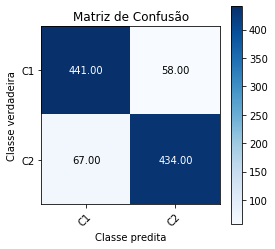

In [42]:
y_pred = md.predict(x_teste)

print('_' * 60)
print("Acurácia:")
print(f"{np.mean(y_pred == y_teste_view) * 100}%")
print('_' * 60)
print("Relatório da classificação:")
print()
print(classification_report(y_teste_view, y_pred, target_names=["C1", "C2"]))
print('_' * 60)

labels = ["C1", "C2"]

cfm = confusion_matrix(y_teste_view, y_pred)

plt.figure(figsize=(4, 4))
ax = plt.subplot(1, 1, 1)
im = plt.imshow(cfm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cfm.shape[1]),
       yticks=np.arange(cfm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=labels, yticklabels=labels,
       title="Matriz de Confusão",
       ylabel='Classe verdadeira',
       xlabel='Classe predita')
# Rotate the tick labels and set their alignment.

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
# Loop over data dimensions and create text annotations.

thresh = cfm.max() / 2.
for i in range(cfm.shape[0]):
    for j in range(cfm.shape[1]):
        ax.text(j, i, format(cfm[i, j], '.2f'),
                ha="center", va="center",
                color="white" if cfm[i, j] > thresh else "black")

ax.set_xlim(-0.5, 1.5)
ax.set_ylim(1.5, -0.5)

<h4>Fronteiras de decisão</h4><br>

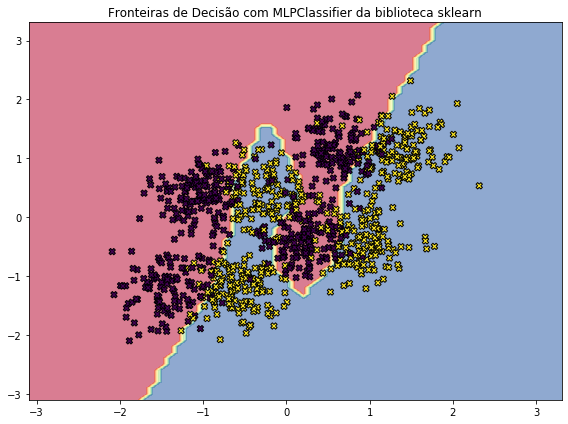

In [43]:
Z = md.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.title("Fronteiras de Decisão com MLPClassifier da biblioteca sklearn")
plt.contourf(xx, yy, Z, alpha=0.6, cmap='Spectral')
plt.scatter(x_teste.to_numpy()[:, 0], x_teste.to_numpy()[:, 1], c=y_teste_view, s=40, edgecolor='k', marker='X')
plt.tight_layout()
plt.show()

<h3>##########################################################################################</h3>
<h3>2.1.2 - MLP - Teste 2</h3>

<p><h4>Principais configurações do teste 2</h4>

'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)], <br>
'activation': ['tanh', 'relu'], <br>
'solver': ['sgd', 'adam'], <br>
'alpha': [0.0001, 0.05], <br>
'learning_rate': ['constant','adaptive'], <br> <br>

<h4>Ainda utilizando MLPClassifier, porém com uma variação maior dos hiperparametros, que são:</h4><p>

In [10]:
mlp = MLPClassifier(max_iter=500)

parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [11]:
print('_' * 60)

from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(x_treino, y_treino_view)

Ainda utilizando MLPClassifier, porém com uma variação maior dos hiperparametros, que são:
____________________________________________________________


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=500,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_sta...
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alph

<h3>2.1.2.1 - MLP - Teste 2</h3>
<h3>Resultados gerais:</h3>

In [56]:
# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) para -> %r" % (mean, std * 2, params))
    print("")


---------- Alguns resultados obtidos ------------

0.671 (+/-0.026) para -> {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}

0.871 (+/-0.039) para -> {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}

0.670 (+/-0.029) para -> {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}

0.875 (+/-0.054) para -> {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}

0.666 (+/-0.039) para -> {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'sgd'}

0.880 (+/-0.044) para -> {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}

0.667 (+/-0.027) para -> {'activation': 'tanh', 'alpha'

<h3>2.1.2.2 - MLP - Teste 2</h3>
<h3>Melhor resultado</h3><br>


In [12]:
# Best paramete set

print('Hiperparametros:\n\n', clf.best_params_)
print('_' * 60)

Hiperparametros:

 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
____________________________________________________________


____________________________________________________________
Resultados:

____________________________________________________________
              precision    recall  f1-score   support

          C1       0.87      0.90      0.88       499
          C2       0.90      0.86      0.88       501

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000

____________________________________________________________


(1.5, -0.5)

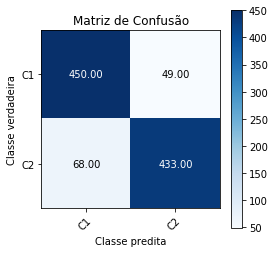

In [22]:
y_true, y_pred = y_teste_view , clf.predict(x_teste)

from sklearn.metrics import classification_report

print('_' * 60)
print("Resultados:")
print()
print('_' * 60)
print(classification_report(y_true, y_pred, target_names=["C1", "C2"]))

labels = ["C1", "C2"]

cfm = confusion_matrix(y_true, y_pred)

print('_' * 60)

plt.figure(figsize=(4, 4))
ax = plt.subplot(1, 1, 1)
im = plt.imshow(cfm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cfm.shape[1]),
       yticks=np.arange(cfm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=labels, yticklabels=labels,
       title="Matriz de Confusão",
       ylabel='Classe verdadeira',
       xlabel='Classe predita')
# Rotate the tick labels and set their alignment.

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
# Loop over data dimensions and create text annotations.

thresh = cfm.max() / 2.
for i in range(cfm.shape[0]):
    for j in range(cfm.shape[1]):
        ax.text(j, i, format(cfm[i, j], '.2f'),
                ha="center", va="center",
                color="white" if cfm[i, j] > thresh else "black")

ax.set_xlim(-0.5, 1.5)
ax.set_ylim(1.5, -0.5)

<h3><br>Fronteiras de decição</h3>

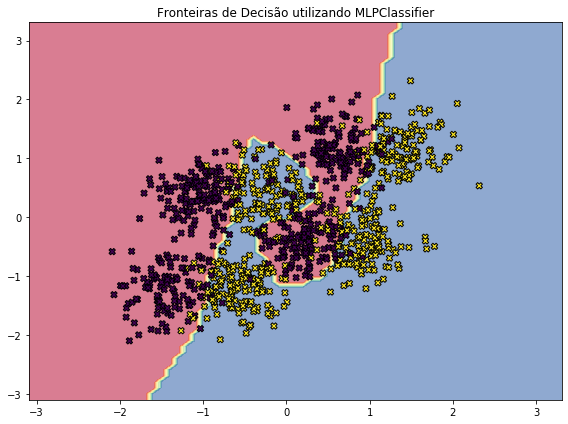

In [39]:
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.title("Fronteiras de Decisão utilizando MLPClassifier")
plt.contourf(xx, yy, Z, alpha=0.6, cmap='Spectral')
plt.scatter(x_teste.to_numpy()[:, 0], x_teste.to_numpy()[:, 1], c=y_teste_view, s=40, edgecolor='k', marker='X')
plt.tight_layout()
plt.show()

In [7]:
#plt.plot(md.loss_curve_, label="Loss")
#plt.legend()
#plt.xlabel("Épocas")
#plt.ylabel("Perdas")
#plt.tight_layout()
#plt.show()

<h3>2.2 - Testes utilizando Keras</h3>

<h3>2.2.1 - Teste 3: </h3>

<p>
- 2 camadas densamente conectadas: <br>
- 1ª com 100 neuronios, função de ativação relu<br>
- 2ª com 2 neuronios de saida, função de classificação softmax<br>
- Otimizador Adam com passo de aprendizado 1e-3<br>
- Loss: Entropia cruzada <br>
- Métrica: Acurácia<br>
- epochs: 300 <br>
- batch_size: 28<br>
</p>

In [24]:
#optimizer = SGD(lr=1e-4, momentum=0.9, nesterov=True)
#optimizer = RMSprop(lr=1e-4)
optimizer = Adam(lr=1e-3, amsgrad=False)

model = Sequential(name="Multi Layer Perceptron")
model.add(Dense(units=100, activation='relu', input_dim=2, name="Camada_de_entrada"))
model.add(Dense(units=2, activation='softmax', name="Camada_de_saida"))
model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

print(model.summary())

print("")
print("_" * 65)
print("")
print("Alguns hiperparametros utilizados para otimização: ")
print("")
for key, value in optimizer.get_config().items():
    try:
        value = np.round(value, 5)
    except:
        pass
    print(f"{key}: {value}")

Model: "Multi Layer Perceptron"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Camada_de_entrada (Dense)    (None, 100)               300       
_________________________________________________________________
Camada_de_saida (Dense)      (None, 2)                 202       
Total params: 502
Trainable params: 502
Non-trainable params: 0
_________________________________________________________________
None

_________________________________________________________________

Alguns hiperparametros utilizados para otimização: 

learning_rate: 0.001
beta_1: 0.9
beta_2: 0.999
decay: 0.0
epsilon: 0.0
amsgrad: False


In [26]:
history = model.fit(x_treino, y_treino,
                    epochs=300,
                    batch_size=28,
                    shuffle=True,
                    verbose=False,
                    validation_data=(x_validacao, y_validacao))

<h3>2.2.1 - Teste 3</h3>
<h3>Resultados</h3>

<p>No caso do framework keras existe a possibilidade de avaliação do conjunto de validação conforme o andamento do aprendizado da Rede.

Os gráficos abaixo apresentam a Loss / Accuracy para os dados de treinamento e validação ao longos das épocas.

A escolha pelo softmax fora apenas para exercitar uma Rede Neural multiclasse padrão, no caso a camada de saída poderia ter como ativação a Função Logística (sigmoid). </p>

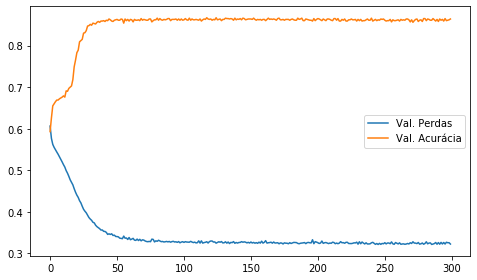

In [27]:
plt.figure(figsize=(13, 4))

plt.subplot(1, 2, 2)
plt.plot(history.history["val_loss"], label="Val. Perdas")
plt.plot(history.history["val_accuracy"], label="Val. Acurácia")
plt.legend()
plt.tight_layout()
plt.show()

<h3>2.2.1 - Teste 3</h3>
<p>Resultados do modelo nos dados de testes.</p>

____________________________________________________________
Acurácia:
88.0%

____________________________________________________________
Relatório da classificação:

              precision    recall  f1-score   support

          C1       0.87      0.89      0.88       499
          C2       0.89      0.87      0.88       501

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



(1.5, -0.5)

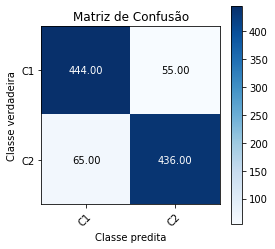

In [40]:
y_pred = np.argmax(model.predict(x_teste, batch_size=32), axis=1)
y_pred[y_pred == 0] = -1

print('_' * 60)
print("Acurácia:")
print(f"{np.mean(y_pred == y_teste_view) * 100}%")
print("")
print('_' * 60)
print("Relatório da classificação:")
print("")
print(classification_report(y_teste_view, y_pred, target_names=["C1", "C2"]))

labels = ["C1", "C2"]
cfm = confusion_matrix(y_teste_view, y_pred)

plt.figure(figsize=(4, 4))
ax = plt.subplot(1, 1, 1)
im = plt.imshow(cfm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cfm.shape[1]),
       yticks=np.arange(cfm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=labels, yticklabels=labels,
       title="Matriz de Confusão",
       ylabel='Classe verdadeira',
       xlabel='Classe predita')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
# Loop over data dimensions and create text annotations.
thresh = cfm.max() / 2.
for i in range(cfm.shape[0]):
    for j in range(cfm.shape[1]):
        ax.text(j, i, format(cfm[i, j], '.2f'),
                ha="center", va="center",
                color="white" if cfm[i, j] > thresh else "black")
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(1.5, -0.5)

<h3>2.2.1 - Teste 3</h3>
<h3>Fronteiras de decisão</h3>

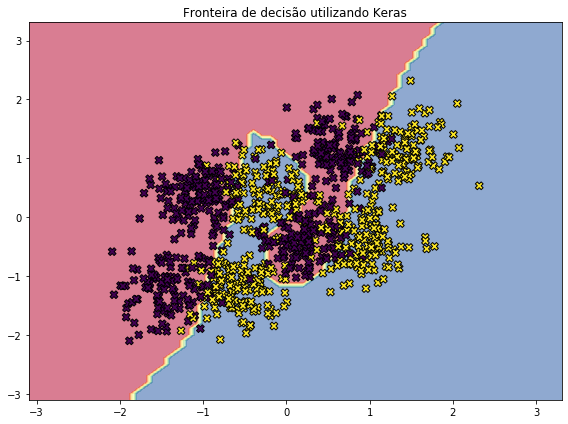

In [87]:
Z = np.argmax(model.predict(np.c_[xx.ravel(), yy.ravel()], batch_size=32), axis=1)
Z[Z == 0] = -1
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.title("Fronteira de decisão utilizando Keras")
plt.contourf(xx, yy, Z, alpha=0.6, cmap='Spectral')
plt.scatter(x_teste.to_numpy()[:, 0], x_teste.to_numpy()[:, 1], c=y_teste_view, s=60, edgecolor='k', marker='X')
plt.tight_layout()
plt.show()

<h3>____________________________________________________________</h3>


"Como é possível notar a Rede Neural construída via Keras teve uma pequena melhor performance, provavelmente devido ao fato menor hiperparamentrização (a rede do scikit-learn pré-configura diversos outros parâmetros como por exemplo regularização). Também pode ser visto que a Rede via Keras converge mais rápido (menos épocas).

Será portanto utilizada a Rede do Keras para experimentar o uso de mais unidades (neurônios na camada intermediária). Para teste (e pensando na questão de uma Rede Neural ser um Aproximador Universal), aumentou-se de maneira relativamente expressiva a quantidade de unidades da camada intermediária para 32768 ao invés de 100."

<h3>2.2.2 - Teste 4 - utilizando Keras com 30.000 neuônios</h3>

Para o teste 4, utilizou-se 30.000 neurônios na camada de entrada, numero este, escolhido de acordo com a documentação do framework Keras, sendo citado como um valor extramamente alto, para que possamos, posteriormente, fazer um comparação entre valores extremamente grande para neuronios e, outrora, valores minimos para os neurônios

In [29]:
print('_' * 60)


# optimizer = SGD(lr=0.001, momentum=0.9, nesterov=True)
# optimizer = RMSprop(lr=0.001)
optimizer = Adam(lr=1e-3, amsgrad=True)

model = Sequential(name="Multi Layer Perceptron")
model.add(Dense(units=30000, activation='relu', input_dim=2, name="Camada_Entrada"))
model.add(Dense(units=2, activation='softmax', name="Camada_Saida"))
model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

print(model.summary())

print()
print("_" * 60)
print("Alguns hiperparametros utilizados para otimização: ")
for key, value in optimizer.get_config().items():
    try:
        value = np.round(value, 5)
    except:
        pass
    print(f"- {key}: {value}")

____________________________________________________________
Model: "Multi Layer Perceptron"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Camada_Entrada (Dense)       (None, 30000)             90000     
_________________________________________________________________
Camada_Saida (Dense)         (None, 2)                 60002     
Total params: 150,002
Trainable params: 150,002
Non-trainable params: 0
_________________________________________________________________
None

____________________________________________________________
Alguns hiperparametros utilizados para otimização: 
- learning_rate: 0.001
- beta_1: 0.9
- beta_2: 0.999
- decay: 0.0
- epsilon: 0.0
- amsgrad: True


In [30]:
history = model.fit(x_treino, y_treino,
                    epochs=100,
                    batch_size=32,
                    shuffle=True,
                    verbose=False,
                    validation_data=(x_validacao, y_validacao))

<h3>2.2.2 - Teste 4</h3>

Resultados obtidos em relação ao conjunto de validação

Aluns hiperparametros utilizados


epochs=100,
batch_size=32,
shuffle=True,
verbose=False,

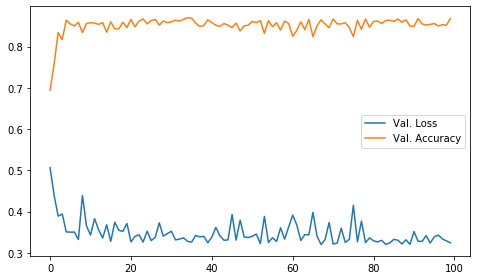

In [31]:
plt.figure(figsize=(13, 4))

plt.subplot(1, 2, 2)
plt.plot(history.history["val_loss"], label="Val. Loss")
plt.plot(history.history["val_accuracy"], label="Val. Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

____________________________________________________________
Acurácia:
88.0%

____________________________________________________________
Relatório da classificação:

              precision    recall  f1-score   support

          C1       0.87      0.89      0.88       499
          C2       0.89      0.87      0.88       501

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



(1.5, -0.5)

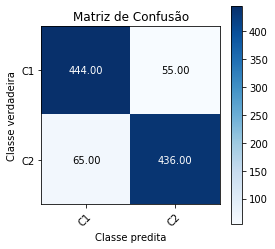

In [42]:
y_pred = np.argmax(model.predict(x_teste, batch_size=32), axis=1)
y_pred[y_pred == 0] = -1

print('_' * 60)
print("Acurácia:")
print(f"{np.mean(y_pred == y_teste_view) * 100}%")
print("")
print('_' * 60)
print("Relatório da classificação:")
print("")
print(classification_report(y_teste_view, y_pred, target_names=["C1", "C2"]))

labels = ["C1", "C2"]
cfm = confusion_matrix(y_teste_view, y_pred)

plt.figure(figsize=(4, 4))
ax = plt.subplot(1, 1, 1)
im = plt.imshow(cfm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cfm.shape[1]),
       yticks=np.arange(cfm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=labels, yticklabels=labels,
       title="Matriz de Confusão",
       ylabel='Classe verdadeira',
       xlabel='Classe predita')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
# Loop over data dimensions and create text annotations.
thresh = cfm.max() / 2.
for i in range(cfm.shape[0]):
    for j in range(cfm.shape[1]):
        ax.text(j, i, format(cfm[i, j], '.2f'),
                ha="center", va="center",
                color="white" if cfm[i, j] > thresh else "black")
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(1.5, -0.5)

<h3>2.2.2 - Teste 4</h3>
<h3>Fronteiras de decisão</h3>

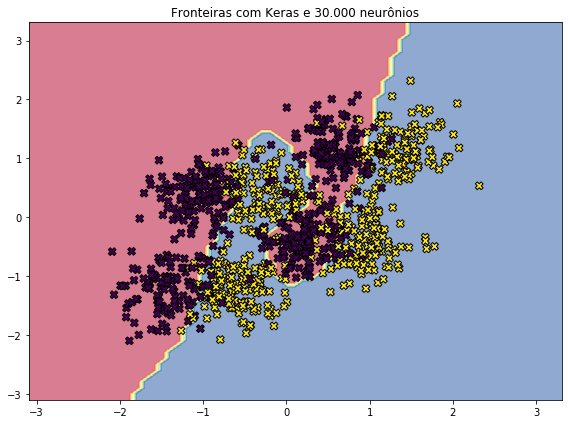

In [33]:
Z = np.argmax(model.predict(np.c_[xx.ravel(), yy.ravel()], batch_size=32), axis=1)
Z[Z == 0] = -1
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.title("Fronteiras com Keras e 30.000 neurônios")
plt.contourf(xx, yy, Z, alpha=0.6, cmap='Spectral')
plt.scatter(x_teste.to_numpy()[:, 0], x_teste.to_numpy()[:, 1], c=y_teste_view, s=60, edgecolor='k', marker='X')
plt.tight_layout()
plt.show()

<h3>2.2.3 - Teste 5 - Mais camadas</h3>

Para este teste, utilizaremos  5 camadas intermediárias, com função de ativação ReLu e softmax para classificação

In [34]:
# optimizer = SGD(lr=0.001, momentum=0.9, nesterov=True)
# optimizer = RMSprop(lr=0.001)
optimizer = Adam(lr=1e-3, amsgrad=True)

model = Sequential(name="Multi Layer Perceptron")
model.add(Dense(units=1024, activation='relu', input_dim=2, name="Input_Layer_1"))
model.add(Dense(units=1024, activation='relu', input_dim=1024, name="Input_Layer_2"))
model.add(Dense(units=1024, activation='relu', input_dim=1024, name="Input_Layer_3"))
model.add(Dense(units=1024, activation='relu', input_dim=1024, name="Input_Layer_4"))
model.add(Dense(units=1024, activation='relu', input_dim=1024, name="Input_Layer_5"))
model.add(Dense(units=2, activation='softmax', name="Output_Layer"))
model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

print(model.summary())

print()
print("_" * 60)
print("Alguns hiperparametros utilizados para otimização: ")
for key, value in optimizer.get_config().items():
    try:
        value = np.round(value, 5)
    except:
        pass
    print(f"- {key}: {value}")

Model: "Multi Layer Perceptron"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer_1 (Dense)        (None, 1024)              3072      
_________________________________________________________________
Input_Layer_2 (Dense)        (None, 1024)              1049600   
_________________________________________________________________
Input_Layer_3 (Dense)        (None, 1024)              1049600   
_________________________________________________________________
Input_Layer_4 (Dense)        (None, 1024)              1049600   
_________________________________________________________________
Input_Layer_5 (Dense)        (None, 1024)              1049600   
_________________________________________________________________
Output_Layer (Dense)         (None, 2)                 2050      
Total params: 4,203,522
Trainable params: 4,203,522
Non-trainable params: 0
__________________________________

In [35]:
history = model.fit(x_treino, y_treino,
                    epochs=100,
                    batch_size=32,
                    shuffle=True,
                    verbose=False,
                    validation_data=(x_validacao, y_validacao))

<h3>2.2.3 - Teste 5</h3>


Resultados obtidos

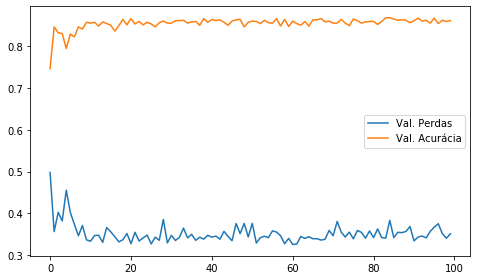

In [36]:
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history["val_loss"], label="Val. Perdas")
plt.plot(history.history["val_accuracy"], label="Val. Acurácia")
plt.legend()
plt.tight_layout()
plt.show()

____________________________________________________________
Acurácia:
88.0%

____________________________________________________________
Relatório da classificação:

              precision    recall  f1-score   support

          C1       0.87      0.89      0.88       499
          C2       0.89      0.87      0.88       501

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



(1.5, -0.5)

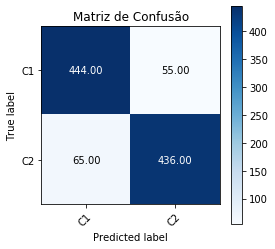

In [43]:
y_pred = np.argmax(model.predict(x_teste, batch_size=32), axis=1)
y_pred[y_pred == 0] = -1

print('_' * 60)
print("Acurácia:")
print(f"{np.mean(y_pred == y_teste_view) * 100}%")
print("")
print('_' * 60)
print("Relatório da classificação:")
print("")
print(classification_report(y_teste_view, y_pred, target_names=["C1", "C2"]))

labels = ["C1", "C2"]
cfm = confusion_matrix(y_teste_view, y_pred)

plt.figure(figsize=(4, 4))
ax = plt.subplot(1, 1, 1)
im = plt.imshow(cfm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cfm.shape[1]),
       yticks=np.arange(cfm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=labels, yticklabels=labels,
       title="Matriz de Confusão",
       ylabel='Classe verdadeira',
       xlabel='Classe predita')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
# Loop over data dimensions and create text annotations.
thresh = cfm.max() / 2.
for i in range(cfm.shape[0]):
    for j in range(cfm.shape[1]):
        ax.text(j, i, format(cfm[i, j], '.2f'),
                ha="center", va="center",
                color="white" if cfm[i, j] > thresh else "black")
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(1.5, -0.5)

<h3>2.2.3 - Teste 5</h3>
<h3>Fronteiras de decisão</h3>

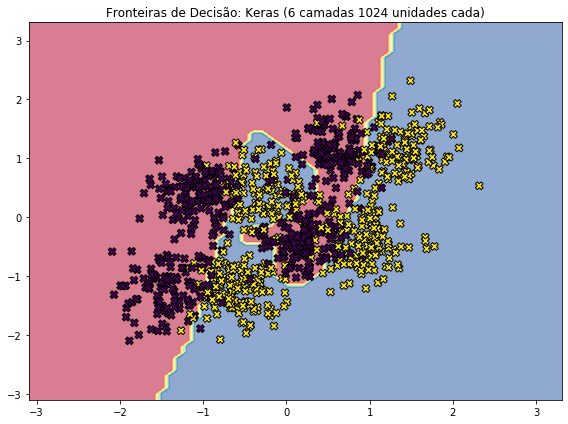

In [38]:
Z = np.argmax(model.predict(np.c_[xx.ravel(), yy.ravel()], batch_size=32), axis=1)
Z[Z == 0] = -1
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.title("Fronteiras de Decisão: Keras (6 camadas 1024 unidades cada)")
plt.contourf(xx, yy, Z, alpha=0.6, cmap='Spectral')
plt.scatter(x_teste.to_numpy()[:, 0], x_teste.to_numpy()[:, 1], c=y_teste_view, s=60, edgecolor='k', marker='X')


plt.tight_layout()
plt.show()

<h3>2.2.4 - Teste 6</h3>
<h4>Minima quantidade de neuronios</h4>

In [47]:
# optimizer = SGD(lr=0.001, momentum=0.9, nesterov=True)
# optimizer = RMSprop(lr=0.001)
optimizer = Adam(lr=1e-3, amsgrad=True)

model = Sequential(name="Multi Layer Perceptron")
model.add(Dense(units=30, activation='relu', input_dim=2, name="Input_Layer_1"))
model.add(Dense(units=2, activation='softmax', name="Output_Layer"))
model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

print(model.summary())

print()
print("_" * 60)
print("Alguns hiperparametros utilizados para otimização: ")
for key, value in optimizer.get_config().items():
    try:
        value = np.round(value, 5)
    except:
        pass
    print(f"- {key}: {value}")

history = model.fit(x_treino, y_treino,
                    epochs=100,
                    batch_size=32,
                    shuffle=True,
                    verbose=False,
                    validation_data=(x_validacao, y_validacao))

Model: "Multi Layer Perceptron"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer_1 (Dense)        (None, 30)                90        
_________________________________________________________________
Output_Layer (Dense)         (None, 2)                 62        
Total params: 152
Trainable params: 152
Non-trainable params: 0
_________________________________________________________________
None

____________________________________________________________
Alguns hiperparametros utilizados para otimização: 
- learning_rate: 0.001
- beta_1: 0.9
- beta_2: 0.999
- decay: 0.0
- epsilon: 0.0
- amsgrad: True


<h3>2.2.4 - Teste 6</h3>
<h4>Resulados:</h4>

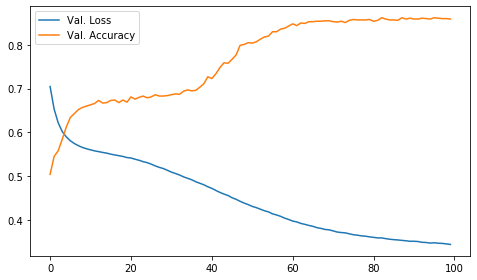

In [48]:
plt.figure(figsize=(13, 4))

plt.subplot(1, 2, 2)
plt.plot(history.history["val_loss"], label="Val. Loss")
plt.plot(history.history["val_accuracy"], label="Val. Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

____________________________________________________________

Acurácia:
87.8%

____________________________________________________________
Relatório da classificação:

              precision    recall  f1-score   support

          C1       0.87      0.89      0.88       499
          C2       0.88      0.87      0.88       501

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



(1.5, -0.5)

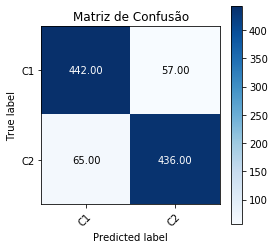

In [49]:
y_pred = np.argmax(model.predict(x_teste, batch_size=32), axis=1)
y_pred[y_pred == 0] = -1

print('_' * 60)
print("")
print("Acurácia:")
print(f"{np.mean(y_pred == y_teste_view) * 100}%")
print("")
print('_' * 60)
print("Relatório da classificação:")
print("")
print(classification_report(y_teste_view, y_pred, target_names=["C1", "C2"]))

labels = ["C1", "C2"]
cfm = confusion_matrix(y_teste_view, y_pred)

plt.figure(figsize=(4, 4))
ax = plt.subplot(1, 1, 1)
im = plt.imshow(cfm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cfm.shape[1]),
       yticks=np.arange(cfm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=labels, yticklabels=labels,
       title="Matriz de Confusão",
       ylabel='Classe verdadeira',
       xlabel='Classe predita')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
# Loop over data dimensions and create text annotations.
thresh = cfm.max() / 2.
for i in range(cfm.shape[0]):
    for j in range(cfm.shape[1]):
        ax.text(j, i, format(cfm[i, j], '.2f'),
                ha="center", va="center",
                color="white" if cfm[i, j] > thresh else "black")
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(1.5, -0.5)

<h3>2.2.4 - Teste 6</h3>
<h4>Fronteiras de decisão:</h4>

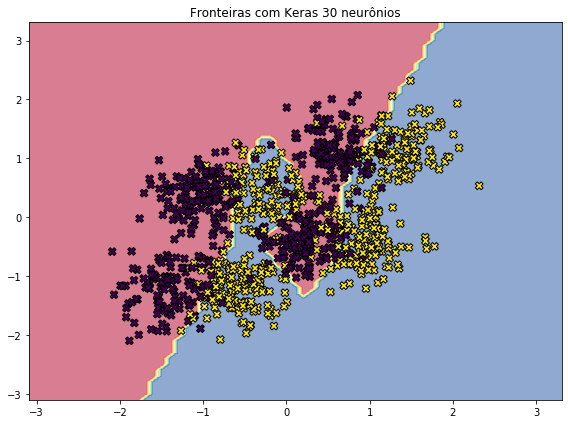

In [50]:
Z = np.argmax(model.predict(np.c_[xx.ravel(), yy.ravel()], batch_size=32), axis=1)
Z[Z == 0] = -1
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.title("Fronteiras com Keras 30 neurônios")
plt.contourf(xx, yy, Z, alpha=0.6, cmap='Spectral')
plt.scatter(x_teste.to_numpy()[:, 0], x_teste.to_numpy()[:, 1], c=y_teste_view, s=60, edgecolor='k', marker='X')

plt.tight_layout()
plt.show()

<h2>2.3 - SVM</h2>

<h3>2.3.1 - SVM Teste 1 </h3>

<p>Alguns hiperparametros utilizados

'C': 5,<br>
'gamma': 'scale',<br>
'kernel': 'rbf',<br>
'random_state': 1<br>
<p>

In [51]:
md = SVC(**{
    'C': 5,
    'gamma': 'scale',
    'kernel': 'rbf',
    'random_state': 1
})
md.fit(x_treino, y_treino_view)

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)

____________________________________________________________

Acurácia:
87.5%
____________________________________________________________
Relatório da classificação:

              precision    recall  f1-score   support

          C1       0.87      0.89      0.88       499
          C2       0.88      0.86      0.87       501

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.87      1000
weighted avg       0.88      0.88      0.87      1000



(1.5, -0.5)

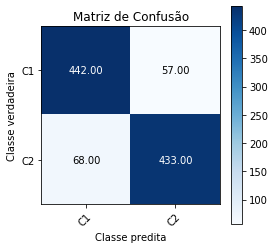

In [52]:
y_pred = md.predict(x_teste)


print('_' * 60)
print("")
print("Acurácia:")
print(f"{np.mean(y_pred == y_teste_view) * 100}%")

print('_' * 60)
print("Relatório da classificação:")
print("")
print(classification_report(y_teste_view, y_pred, target_names=["C1", "C2"]))

labels = ["C1", "C2"]
cfm = confusion_matrix(y_teste_view, y_pred)

plt.figure(figsize=(4, 4))
ax = plt.subplot(1, 1, 1)
im = plt.imshow(cfm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cfm.shape[1]),
       yticks=np.arange(cfm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=labels, yticklabels=labels,
       title="Matriz de Confusão",
       ylabel='Classe verdadeira',
       xlabel='Classe predita')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
# Loop over data dimensions and create text annotations.
thresh = cfm.max() / 2.
for i in range(cfm.shape[0]):
    for j in range(cfm.shape[1]):
        ax.text(j, i, format(cfm[i, j], '.2f'),
                ha="center", va="center",
                color="white" if cfm[i, j] > thresh else "black")
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(1.5, -0.5)

<h3>2.3.1 - SVM Teste 1 </h3>
<h4>Fronteiras de decisão</h4>

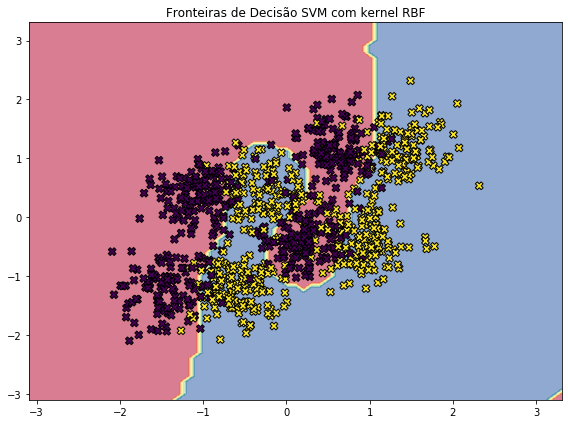

In [54]:
Z = md.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.title("Fronteiras de Decisão SVM com kernel RBF")

plt.contourf(xx, yy, Z, alpha=0.6, cmap='Spectral')
plt.scatter(x_teste.to_numpy()[:, 0], x_teste.to_numpy()[:, 1], c=y_teste_view, s=60, edgecolor='k', marker='X')

plt.tight_layout()
plt.show()

<h3>2.3.2 - SVM - Teste 2</h3>

In [55]:
md = SVC(**{
    "C": 5,
    "gamma": 'scale',
    "kernel": 'poly',
    "degree": 3,
    "random_state": 1
})
md.fit(x_treino, y_treino_view)

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)

____________________________________________________________

Acurácia:
75.9%
____________________________________________________________
Relatório da classificação:

              precision    recall  f1-score   support

          C1       0.72      0.83      0.78       499
          C2       0.81      0.68      0.74       501

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.77      0.76      0.76      1000



(1.5, -0.5)

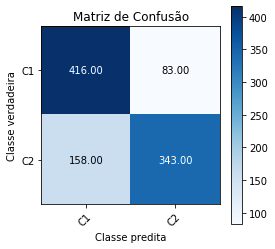

In [57]:
y_pred = md.predict(x_teste)

print('_' * 60)
print("")
print("Acurácia:")
print(f"{np.mean(y_pred == y_teste_view) * 100}%")

print('_' * 60)
print("Relatório da classificação:")
print("")
print(classification_report(y_teste_view, y_pred, target_names=["C1", "C2"]))

labels = ["C1", "C2"]
cfm = confusion_matrix(y_teste_view, y_pred)

plt.figure(figsize=(4, 4))
ax = plt.subplot(1, 1, 1)
im = plt.imshow(cfm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cfm.shape[1]),
       yticks=np.arange(cfm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=labels, yticklabels=labels,
       title="Matriz de Confusão",
       ylabel='Classe verdadeira',
       xlabel='Classe predita')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
# Loop over data dimensions and create text annotations.
thresh = cfm.max() / 2.
for i in range(cfm.shape[0]):
    for j in range(cfm.shape[1]):
        ax.text(j, i, format(cfm[i, j], '.2f'),
                ha="center", va="center",
                color="white" if cfm[i, j] > thresh else "black")
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(1.5, -0.5)

<h3>2.3.2 - SVM Teste 2 </h3>
<h4>Fronteiras de decisão</h4>

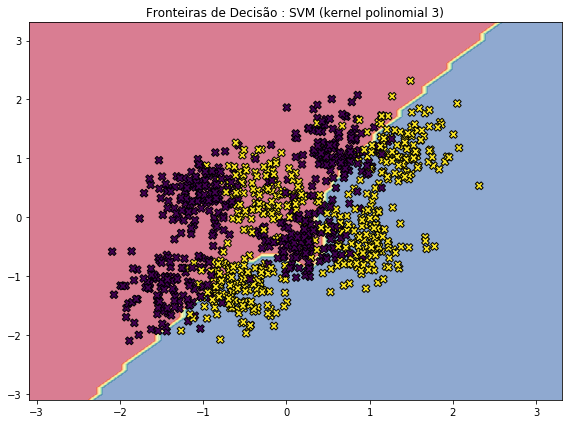

In [58]:
Z = md.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.title("Fronteiras de Decisão : SVM (kernel polinomial 3)")
plt.contourf(xx, yy, Z, alpha=0.6, cmap='Spectral')
plt.scatter(x_teste.to_numpy()[:, 0], x_teste.to_numpy()[:, 1], c=y_teste_view, s=60, edgecolor='k', marker='X')

plt.tight_layout()
plt.show()

<h3>2.3.3 - SVM - Teste 3</h3>

In [59]:
md = SVC(**{
    "C": 5,
    "gamma": 'scale',
    "kernel": 'poly',
    "degree": 9,
    "random_state": 1
})
md.fit(x_treino, y_treino_view)

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=9, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)

____________________________________________________________

Acurácia:
75.1%
____________________________________________________________
Relatório da classificação:

              precision    recall  f1-score   support

          C1       0.68      0.95      0.79       499
          C2       0.91      0.56      0.69       501

    accuracy                           0.75      1000
   macro avg       0.80      0.75      0.74      1000
weighted avg       0.80      0.75      0.74      1000



(1.5, -0.5)

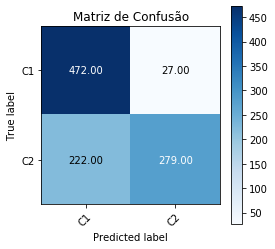

In [60]:
y_pred = md.predict(x_teste)

print('_' * 60)
print("")
print("Acurácia:")
print(f"{np.mean(y_pred == y_teste_view) * 100}%")

print('_' * 60)
print("Relatório da classificação:")
print("")

print(classification_report(y_teste_view, y_pred, target_names=["C1", "C2"]))

labels = ["C1", "C2"]
cfm = confusion_matrix(y_teste_view, y_pred)

plt.figure(figsize=(4, 4))
ax = plt.subplot(1, 1, 1)
im = plt.imshow(cfm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cfm.shape[1]),
       yticks=np.arange(cfm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=labels, yticklabels=labels,
       title="Matriz de Confusão",
       ylabel='True label',
       xlabel='Predicted label')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
# Loop over data dimensions and create text annotations.
thresh = cfm.max() / 2.
for i in range(cfm.shape[0]):
    for j in range(cfm.shape[1]):
        ax.text(j, i, format(cfm[i, j], '.2f'),
                ha="center", va="center",
                color="white" if cfm[i, j] > thresh else "black")
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(1.5, -0.5)

<h3>2.3.3 - SVM Teste 3 </h3>
<h4>Fronteiras de decisão</h4>

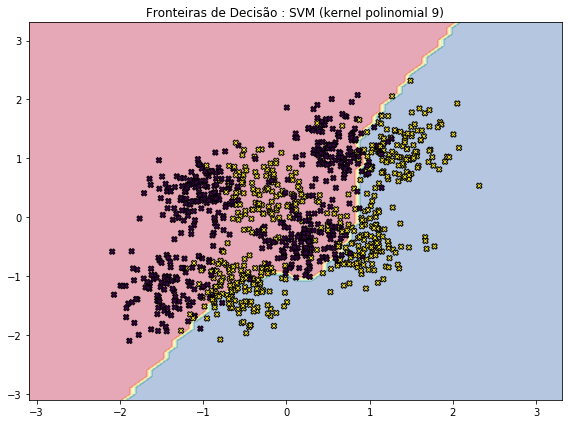

In [61]:
Z = md.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.title("Fronteiras de Decisão : SVM (kernel polinomial 9)")
plt.contourf(xx, yy, Z, alpha=0.4, cmap='Spectral')
plt.scatter(x_teste.to_numpy()[:, 0], x_teste.to_numpy()[:, 1], c=y_teste_view, s=30, edgecolor='k', marker='X')
plt.tight_layout()
plt.show()

<h1>Semestre passado</h1>
<h3>2.4 - MLP Utilizando torch para a criação dos modelos e testes com mini-batch e online </h3>


In [44]:
dataset_treino = scipy.io.loadmat("./dados/dados_treinamento.mat")
dataset_val = scipy.io.loadmat("./dados/dados_val.mat")
dataset_teste = scipy.io.loadmat("./dados/dados_teste.mat")

X_treino = dataset_treino["X"]
y_treino = dataset_treino["y"]
X_val = dataset_val["Xval"]
y_val = dataset_val["yval"]
X_teste = dataset_teste["Xt"]
y_teste = dataset_teste["yt"]

y_treino[y_treino == -1] = 0
y_val[y_val == -1] = 0
y_teste[y_teste == -1] = 0

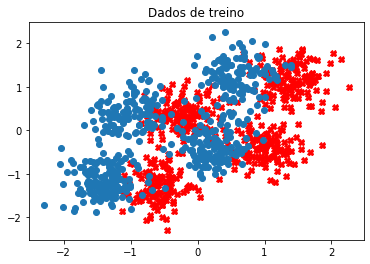

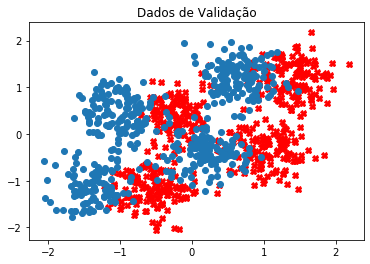

IndexError: index 1 is out of bounds for axis 1 with size 1

In [45]:
plt.plot(X_treino[np.in1d(y_treino, 1), 0], X_treino[np.in1d(y_treino, 1), 1], 'rX')
plt.plot(X_treino[np.in1d(y_treino, 0), 0], X_treino[np.in1d(y_treino, 0), 1], 'o')
plt.title("Dados de treino")
plt.show()

plt.plot(X_val[np.in1d(y_val, 1), 0], X_val[np.in1d(y_val, 1), 1], 'rX')
plt.plot(X_val[np.in1d(y_val, 0), 0], X_val[np.in1d(y_val, 0), 1], 'o')
plt.title("Dados de Validação")
plt.show()

plt.plot(X_teste[np.in1d(y_teste, 1), 0], y_teste[np.in1d(y_teste, 1), 1], 'rX')
plt.plot(X_teste[np.in1d(y_teste, 0), 0], y_teste[np.in1d(y_teste, 0), 1], 'o')
plt.title("Dados de Teste")
plt.show()

<h3>2.4 - MLP Utilizando torch e mini-batch
<h4>Camada oculta variando a quantidade de neurônios em: 5, 10, 15, 30, 50</h4>
    
<p>
Hiperparametros:
    
- classes = 1 <br>
- dim_entrada = 2
- epocas = 10000
- passagens = 1000
- otimizador = Adam
- função de ativação = sigmoid, relu
- dropout = 0,5

<h4>Resultados:</h4>

In [46]:
classes = 1 
dim_entrada = 2
epocas = 10000
passagens = 1000

X_treino_tmp = torch.tensor(X_treino, dtype=torch.float)
y_treino_tmp = torch.tensor(y_treino, dtype=torch.float)
X_val_tmp = torch.tensor(X_val, dtype=torch.float)
y_val_tmp = torch.tensor(y_val, dtype=torch.float)
X_teste_tmp = torch.tensor(X_teste, dtype=torch.float)
y_teste_tmp = torch.tensor(y_teste, dtype=torch.float)

H =  5
Dados de validação: Avg. loss: 0.7163, Acurácia: 558/1000 (56%)
Dados de validação: Avg. loss: 0.5257, Acurácia: 674/1000 (67%)
Dados de validação: Avg. loss: 0.4911, Acurácia: 685/1000 (68%)
Dados de validação: Avg. loss: 0.4814, Acurácia: 690/1000 (69%)
Dados de validação: Avg. loss: 0.4788, Acurácia: 687/1000 (69%)
Dados de validação: Avg. loss: 0.4774, Acurácia: 681/1000 (68%)
Dados de validação: Avg. loss: 0.4767, Acurácia: 683/1000 (68%)
Dados de validação: Avg. loss: 0.4771, Acurácia: 685/1000 (68%)
Dados de validação: Avg. loss: 0.4764, Acurácia: 684/1000 (68%)
Dados de validação: Avg. loss: 0.4761, Acurácia: 684/1000 (68%)


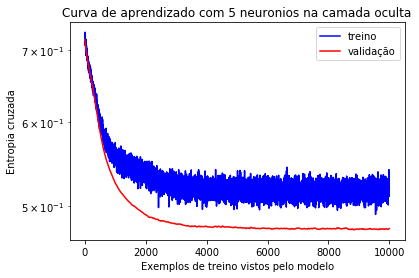

H =  10
Dados de validação: Avg. loss: 0.7609, Acurácia: 413/1000 (41%)
Dados de validação: Avg. loss: 0.5260, Acurácia: 702/1000 (70%)
Dados de validação: Avg. loss: 0.4646, Acurácia: 740/1000 (74%)
Dados de validação: Avg. loss: 0.4461, Acurácia: 755/1000 (76%)
Dados de validação: Avg. loss: 0.4414, Acurácia: 752/1000 (75%)
Dados de validação: Avg. loss: 0.4401, Acurácia: 746/1000 (75%)
Dados de validação: Avg. loss: 0.4379, Acurácia: 744/1000 (74%)
Dados de validação: Avg. loss: 0.4377, Acurácia: 743/1000 (74%)
Dados de validação: Avg. loss: 0.4377, Acurácia: 746/1000 (75%)
Dados de validação: Avg. loss: 0.4367, Acurácia: 747/1000 (75%)


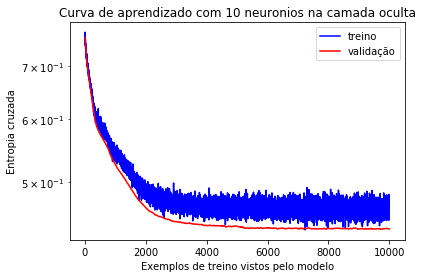

H =  15
Dados de validação: Avg. loss: 0.7583, Acurácia: 443/1000 (44%)
Dados de validação: Avg. loss: 0.5061, Acurácia: 684/1000 (68%)
Dados de validação: Avg. loss: 0.4474, Acurácia: 714/1000 (71%)
Dados de validação: Avg. loss: 0.4271, Acurácia: 805/1000 (80%)
Dados de validação: Avg. loss: 0.4177, Acurácia: 812/1000 (81%)
Dados de validação: Avg. loss: 0.4163, Acurácia: 826/1000 (83%)
Dados de validação: Avg. loss: 0.4161, Acurácia: 820/1000 (82%)
Dados de validação: Avg. loss: 0.4160, Acurácia: 824/1000 (82%)
Dados de validação: Avg. loss: 0.4164, Acurácia: 823/1000 (82%)
Dados de validação: Avg. loss: 0.4167, Acurácia: 822/1000 (82%)


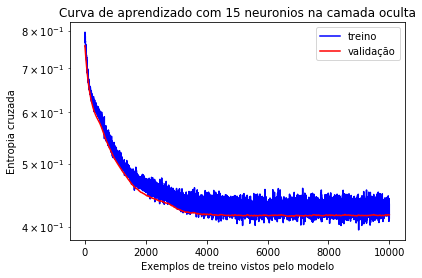

H =  30
Dados de validação: Avg. loss: 0.7348, Acurácia: 519/1000 (52%)
Dados de validação: Avg. loss: 0.4643, Acurácia: 731/1000 (73%)
Dados de validação: Avg. loss: 0.4185, Acurácia: 776/1000 (78%)
Dados de validação: Avg. loss: 0.4083, Acurácia: 823/1000 (82%)
Dados de validação: Avg. loss: 0.3981, Acurácia: 840/1000 (84%)
Dados de validação: Avg. loss: 0.3925, Acurácia: 847/1000 (85%)
Dados de validação: Avg. loss: 0.3946, Acurácia: 852/1000 (85%)
Dados de validação: Avg. loss: 0.3955, Acurácia: 853/1000 (85%)
Dados de validação: Avg. loss: 0.3961, Acurácia: 846/1000 (85%)
Dados de validação: Avg. loss: 0.3965, Acurácia: 852/1000 (85%)


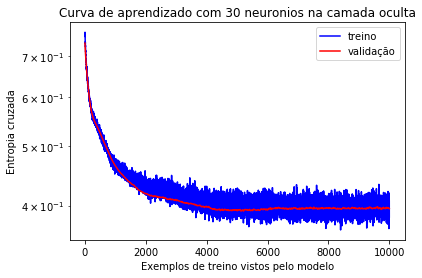

H =  50
Dados de validação: Avg. loss: 0.7035, Acurácia: 381/1000 (38%)
Dados de validação: Avg. loss: 0.4155, Acurácia: 831/1000 (83%)
Dados de validação: Avg. loss: 0.3736, Acurácia: 863/1000 (86%)
Dados de validação: Avg. loss: 0.3725, Acurácia: 858/1000 (86%)
Dados de validação: Avg. loss: 0.3731, Acurácia: 859/1000 (86%)
Dados de validação: Avg. loss: 0.3742, Acurácia: 858/1000 (86%)
Dados de validação: Avg. loss: 0.3755, Acurácia: 858/1000 (86%)
Dados de validação: Avg. loss: 0.3773, Acurácia: 857/1000 (86%)
Dados de validação: Avg. loss: 0.3764, Acurácia: 856/1000 (86%)
Dados de validação: Avg. loss: 0.3767, Acurácia: 856/1000 (86%)


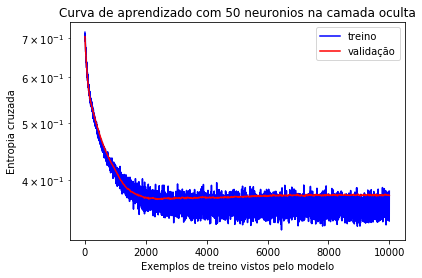

H =  80
Dados de validação: Avg. loss: 0.6810, Acurácia: 579/1000 (58%)
Dados de validação: Avg. loss: 0.3771, Acurácia: 858/1000 (86%)
Dados de validação: Avg. loss: 0.3617, Acurácia: 866/1000 (87%)
Dados de validação: Avg. loss: 0.3616, Acurácia: 857/1000 (86%)
Dados de validação: Avg. loss: 0.3633, Acurácia: 857/1000 (86%)
Dados de validação: Avg. loss: 0.3639, Acurácia: 857/1000 (86%)
Dados de validação: Avg. loss: 0.3666, Acurácia: 857/1000 (86%)


In [ ]:
for H in [5, 10, 15, 30, 50, 80]:
    print("H = ", H)
    perdas_treino = []
    perdas_val = []
    
    modelo = torch.nn.Sequential(torch.nn.Linear(dim_entrada, H), 
                                 torch.nn.ReLU(), 
                                 torch.nn.Dropout(0.5), 
                                 torch.nn.Linear(H, classes),
                                 torch.nn.Sigmoid(),
    )
    
    otimizador = optim.Adam(modelo.parameters())
    
    for epoca in range(epocas):
        modelo.train()
        otimizador.zero_grad()
        saida = modelo(X_treino_tmp)
        perda = F.binary_cross_entropy(saida, y_treino_tmp)
        perda.backward()
        otimizador.step()
        perdas_treino.append(perda)
        
        modelo.eval()
        with torch.no_grad():
            saida = modelo(X_val_tmp)
            perda_validacao = F.binary_cross_entropy(saida, y_val_tmp)
        predicao = np.where(saida<0.5,0,1)
        correcao = y_val_tmp.eq(torch.tensor(predicao, dtype=torch.float)).sum()
        perdas_val.append(perda_validacao)
        if epoca % passagens == 0:
            print('Dados de validação: Avg. loss: {:.4f}, Acurácia: {}/{} ({:.0f}%)'.format(
            perda_validacao, correcao, len(y_val),
            100. * correcao / len(y_val)))
        gc.collect()

    
    plt.plot(perdas_treino, color='blue')
    plt.plot(perdas_val, color='red')
    plt.legend(["treino", "validação"])
    plt.yscale("log")
    plt.title('Curva de aprendizado com {} neuronios na camada oculta'.format(H))
    plt.xlabel('Exemplos de treino vistos pelo modelo')
    plt.ylabel('Entropia cruzada')
    #plt.savefig(pst_imagens, 'curva_bath{}.png'.format(H)), bbox_inches='tight')
    plt.show()

H =  5


NameError: name 'dim_entrada' is not defined

<h3>Online</h3>

In [ ]:
epocas = 200
passagens = 20

for H in [5, 10, 15, 30, 50]:
    print("H = ", H)
    perdas_treino = []
    perdas_val = []
    
    modelo = torch.nn.Sequential(
        torch.nn.Linear(dim_entrada, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, classes),
        torch.nn.Sigmoid(),
    )
    
    otimizador = optim.Adam(modelo.parameters())
    
    for epoca in range(epocas):
        modelo.train()
        for idx, (data, target) in enumerate(zip(torch.tensor(X_treino, dtype=torch.float),
                                                 torch.tensor(y_treino, dtype=torch.float))):
            otimizador.zero_grad()
            saida = modelo(data)
            perda = F.binary_cross_entropy(saida, target)
            perda.backward()
            otimizador.step()
        perdas_treino.append(perda.item())        
    
        modelo.eval()
        perda_val = 0
        correcao = 0
        with torch.no_grad():
            for data, target in zip(torch.tensor(X_val, dtype=torch.float),
                                             torch.tensor(y_val, dtype=torch.float)):
                saida = modelo(data)
                perda_val += F.binary_cross_entropy(saida, target, size_average=False).item()
                pred = torch.round(saida)
                correcao += (1 if pred == target else 0)
        perda_val /= len(y_val)
        perdas_val.append(perda_val)
        if epoca % passagens == 0:
            print('Validação: Avg. loss: {:.4f}, Acurácia: {}/{} ({:.0f}%)'.format(
                perda_val, correcao, len(y_val),
                100. * correcao / len(y_val)))
    
    plt.plot(perdas_treino, color='blue')
    plt.plot(perdas_val, color='red')
    plt.legend(["treino", "validação"])
    plt.yscale("log")
    plt.title('Curva de aprendizado com {} neuronios na camada oculta'.format(H))
    plt.xlabel('Exemplos para treinamento expostos ao modelo')
    plt.ylabel('Entropia Cruzada')
    #plt.savefig(os.path.join(pst_imagens, 'online_curva_h_{}.png'.format(H)), bbox_inches='tight')
    plt.show()

In [ ]:
epocas = 300
H = 30

modelo = torch.nn.Sequential(
        torch.nn.Linear(dim_entrada, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, classes),
        torch.nn.Sigmoid(),
)

X = np.vstack((X_treino, X_val))
y = np.vstack((y_treino, y_val))

otimizador = optim.Adam(modelo.parameters())

for epoca in range(epocas):
    modelo.train()
    for idx, (data, target) in enumerate(zip(torch.tensor(X, dtype=torch.float),
                                     torch.tensor(y, dtype=torch.float))):
        otimizador.zero_grad()
        saida = modelo(data)
        perda = F.binary_cross_entropy(saida, target)
        perda.backward()
        otimizador.step()
    print('.', end='')

In [ ]:
modelo.eval()
perda_teste = 0
correcao = 0
with torch.no_grad():
    for data, target in zip(torch.tensor(X_teste, dtype=torch.float),
                             torch.tensor(y_teste, dtype=torch.float)):
        output = modelo(data)
        perda_teste += F.binary_cross_entropy(output, target, size_average=False).item()
        pred = torch.round(output)
        correcao += (1 if pred == target else 0)
    perda_teste /= len(y_teste)
print('Dados de teste: Avg. loss: {:.4f}, Acurácia: {}/{} ({:.0f}%)'.format(
    perda_teste, correcao, len(y_teste),
    100. * correcao / len(y_teste)))

In [ ]:
X_test_t = torch.FloatTensor(X_teste)
y_hat_test = model(X_test_t)
y_hat_test_class = np.where(y_hat_test.detach().numpy()<0.5, 0, 1)
test_accuracy = np.sum(y_teste.reshape(-1,1)==y_hat_test_class) / len(y_teste)
print("Acurácia de teste {:.2f}".format(test_accuracy))


x_min, x_max = X_treino[:, 0].min()-0.3, X_treino[:, 0].max()+0.3
y_min, y_max = X_treino[:, 1].min()-0.3, X_treino[:, 1].max()+0.3


spacing = min(x_max - x_min, y_max - y_min) / 100


XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing),
               np.arange(y_min, y_max, spacing))


data = np.hstack((XX.ravel().reshape(-1,1), 
                  YY.ravel().reshape(-1,1)))


data_t = torch.FloatTensor(data)
db_prob = model(data_t)

clf = np.where(db_prob<0.5,0,1)

Z = clf.reshape(XX.shape)

plt.figure(figsize=(12,8))
plt.title("Regiões de decisão para o MLP usando {} neuronios na camada intermediária".format(H))
plt.contourf(XX, YY, Z, cmap=plt.cm.coolwarm, alpha=0.5)
plt.plot(X_teste[np.in1d(y_teste, 1), 0], X_teste[np.in1d(y_teste, 1), 1], 'rx')
plt.plot(X_teste[np.in1d(y_teste, 0), 0], X_teste[np.in1d(y_teste, 0), 1], 'b.')
#plt.savefig(os.path.join(pst_imagens, 'mlp_regioes_h_{}.png'.format(H)), bbox_inches='tight')
plt.show()

<h2> SVM </h2>

In [ ]:
clf = SVC(gamma='scale')
clf.fit(X_treino, y_treino.ravel())

In [ ]:
y_pred = clf.predict(X_val)
accuracy_score(y_pred, y_val)

In [ ]:
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    for c in [1, 10, 50, 100]:
        clf = SVC(C=c, kernel=kernel, gamma='scale')
        clf.fit(X_treino, y_treino.ravel())
        
        y_pred = clf.predict(X_val)
        ac = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        auc_score = roc_auc_score(y_val, y_pred)
        
        print('===')
        print('SVM com C =', c, 'e kernel =', kernel)
        print('Acurácia: {}, F1-score: {:.3f}, AUC: {:.3f}'.format(ac, f1, auc_score))
        
        plot_decision_regions(X_val, y_val.ravel(), clf=clf)
        #plt.savefig(os.path.join(pst_imagens, 'regions_svm_{}_{}.png'.format(c, kernel)), bbox_inches='tight')
        plt.show()

In [ ]:
X_test_t = torch.FloatTensor(X_teste)
y_hat_test = modelo(X_test_t)
y_hat_test_class = np.where(y_hat_test.detach().numpy()<0.5, 0, 1)
test_accuracy = np.sum(y_teste.reshape(-1,1)==y_hat_test_class) / len(y_teste)
print("Acurácia de teste {:.2f}".format(test_accuracy))


x_min, x_max = X_treino[:, 0].min()-0.3, X_treino[:, 0].max()+0.3
y_min, y_max = X_treino[:, 1].min()-0.3, X_treino[:, 1].max()+0.3


spacing = min(x_max - x_min, y_max - y_min) / 100


XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing),
               np.arange(y_min, y_max, spacing))


data = np.hstack((XX.ravel().reshape(-1,1), 
                  YY.ravel().reshape(-1,1)))


data_t = torch.FloatTensor(data)
db_prob = modelo(data_t)

clf = np.where(db_prob<0.5,0,1)

Z = clf.reshape(XX.shape)

plt.figure(figsize=(12,8))
plt.title("Regiões de decisão para o MLP usando {} neuronios na camada intermediária".format(H))
plt.contourf(XX, YY, Z, cmap=plt.cm.coolwarm, alpha=0.5)
plt.plot(X_teste[np.in1d(y_teste, 1), 0], X_teste[np.in1d(y_teste, 1), 1], 'rx')
plt.plot(X_teste[np.in1d(y_teste, 0), 0], X_teste[np.in1d(y_teste, 0), 1], 'b.')
#plt.savefig(os.path.join(pst_imagens, 'mlp_regioes_h_{}.png'.format(H)), bbox_inches='tight')
plt.show()

## SVM

In [ ]:
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    for c in [1, 10, 50, 100]:
        clf = SVC(C=c, kernel=kernel, gamma='scale')
        clf.fit(X_treino, y_treino.ravel())
        
        y_pred = clf.predict(X_val)
        ac = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        auc_score = roc_auc_score(y_val, y_pred)
        
        print('===')
        print('SVM com C =', c, 'e kernel =', kernel)
        print('Acurácia: {}, F1-score: {:.3f}, AUC: {:.3f}'.format(ac, f1, auc_score))
        
        plot_decision_regions(X_val, y_val.ravel(), clf=clf)
        #plt.savefig(os.path.join(pst_imagens, 'regions_svm_{}_{}.png'.format(c, kernel)), bbox_inches='tight')
        plt.show()

===
SVM com C = 50 e kernel = rbf
Acurácia: 0.874, F1-score: 0.873, AUC: 0.874


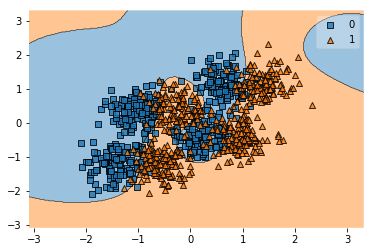

Fim fonte 2 html
</fonte>
</html>